In [ ]:
# Setup and Imports (shared utilities)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
from matplotlib import pyplot as plt

# get the location of this file
main_fpath = os.path.abspath('')
os.chdir(main_fpath)

# Optional interactive widgets
try:
    from ipywidgets import interact, FloatSlider, IntSlider
except Exception:
    interact = None
    FloatSlider = IntSlider = None

# Import shared utilities from the local module
from gen_models_utilities import (
    RNG_SEED, device, _compute_axis_limits, create_ring_gaussians, 
    GanHistory, make_loader,
    compute_diversity_metric, plot_model_diagnostics, plot_latent_interpolation
)

print(f"Using device: {device}")

Using device: cuda


This notebook will highlight some of the original problems with GAN models, some of the techniques you can use to diagnose model errors, and also introduce common rememdies for simple feed-forward GAN models. The next notebook will introduce the concept of Optimal Transport, and show how this mitigates some of the problems caused by the original GAN formulation as a minimax game.

As with the last notebook, we will use the simple Ring of Gaussian Toy example to illustrate this for pedagogical purposes. In later notebooks, we will see how these problems can manifest in more complex settings.

Let's start by loading the dataset again:

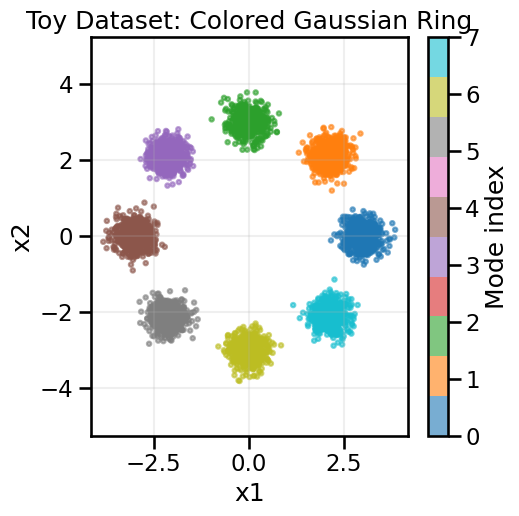

In [2]:
X_ring, y_ring = create_ring_gaussians()
plt.figure(figsize=(5.5,5.5))
sc = plt.scatter(X_ring[:,0], X_ring[:,1], c=y_ring, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(sc, label='Mode index')
plt.title('Toy Dataset: Colored Gaussian Ring')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

ring_latent_limits = ((-3.5, 3.5), (-3.5, 3.5))
ring_data_limits = _compute_axis_limits(X_ring)

We will now run a series of experiments to show you common problems and how they manifest in the plotting visualizations.

## Experiment 1: When the Discriminator Overpowers the Generator

In this experiment, we will see what happens with the Discriminator part of the GAN significantly overpowers the Generator. This can occur because of several reasons:

1. The Discriminator is a much larger (or higher capacity) network than the Generator, and thus is able to move its classification decision boundary in more complex ways to distinguish real from fake samples, and the Generator doesn't have sufficient capacity to compensate for this.
2. The Discriminator trains much faster than the Generator, and thus can move its decision boundary faster than the Generator can keep up.
3. The Discriminator is initialized (either on purpose or by random chance) such that it has an initial significant advantage over the Generator. In this case, even if the Generator has high capacity and can train quickly, it may not be able to recover from this initial disadvantage, as the discriminator make lock it into a portion of the sample space from which local gradient descent on the Generator cannot recover.

We can induce this below by just significantly increasing the learning rate of the Discriminator relative to the Generator. Consider the following questions and experiment:

::: {.callout-tip appearance="default"}
### Experiment: What happens when the Discriminator overpowers the Generator?
Below you can change the relative learning rates of the Discriminator versus the Generator:

- What happens when the Discriminator is able to train significantly faster than the Generator? What about the other way around?
- How can we tell from the various loss plots that the Discriminator is overpowering the Generator? How does this behavior manifest itself in the generated samples?
- Why is it that the generator is unable to recover from this situation, even though it has the capacity to represent the data distribution? What about the training procedure and dynamics of the minimax game prevents the Generator from catching up?
- In the latent interpolation plots, as the GAN spans its latent set of coordinates, what happens to the generated samples?

:::


In [3]:
class MLPGenerator(nn.Module):
    def __init__(self, noise_dim: int = 2, hidden_dim: int = 256, out_dim: int = 2, spectral_normalization: bool = False):
        super().__init__()
        # Create linear layers and optionally apply spectral normalization
        lin1 = nn.Linear(noise_dim, hidden_dim)
        lin2 = nn.Linear(hidden_dim, hidden_dim)
        lin3 = nn.Linear(hidden_dim, out_dim)
        if spectral_normalization:
            from torch.nn.utils import spectral_norm
            lin1 = spectral_norm(lin1)
            lin2 = spectral_norm(lin2)
            lin3 = spectral_norm(lin3)
        self.main = nn.Sequential(
            lin1, nn.LeakyReLU(),
            lin2, nn.LeakyReLU(),
            lin3,
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.main(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, input_dim: int = 2, hidden_dim: int = 256, spectral_normalization: bool = False):
        super().__init__()
        # Optionally apply spectral normalization to linear layers to stabilize training
        layers = []
        lin1 = nn.Linear(input_dim, hidden_dim)
        lin2 = nn.Linear(hidden_dim, hidden_dim)
        lin3 = nn.Linear(hidden_dim, 1)
        if spectral_normalization:
            from torch.nn.utils import spectral_norm
            lin1 = spectral_norm(lin1)
            lin2 = spectral_norm(lin2)
            lin3 = spectral_norm(lin3)
        layers.extend([lin1, nn.LeakyReLU(0.2), lin2, nn.LeakyReLU(0.2), lin3])
        self.main = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x).squeeze(-1)


def build_generator(noise_dim=2, hidden_dim=256, spectral_normalization: bool = False):
    return MLPGenerator(noise_dim=noise_dim, hidden_dim=hidden_dim, spectral_normalization=spectral_normalization).to(device)


def build_discriminator(hidden_dim=256, spectral_normalization: bool = False):
    return MLPDiscriminator(hidden_dim=hidden_dim, spectral_normalization=spectral_normalization).to(device)

In [4]:
#| code-fold: true
def train_vanilla_gan(
    data: np.ndarray, *, noise_dim: int = 2, batch_size: int = 256, epochs: int = 120,
    lr_g: float = 2e-4, lr_d: float = 2e-4, hidden_dim: int = 256, print_every: int = 40,
    spectral_normalization: bool = False, checkpoint_interval: int = 0) -> tuple[nn.Module, nn.Module, GanHistory]:
    # Load the data into a DataLoader for batching and make PyTorch happy
    loader = make_loader(data, batch_size)

    # Set up the basic networks
    G = build_generator(noise_dim=noise_dim, hidden_dim=hidden_dim)
    D = build_discriminator(hidden_dim=hidden_dim, spectral_normalization=spectral_normalization)
    # Instantiate the optimizers for each model
    opt_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    opt_d = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))
    bce = nn.BCEWithLogitsLoss()
    # Record the loss history for plotting later
    hist = GanHistory([], [], [], [], [])

    # Helper to capture a snapshot
    def _capture_snapshot(ep_idx: int):
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            samples = G(z_eval).cpu().numpy()
        # Save a shallow copy of generator state and a small sample for visualization
        state = {k: v.cpu().clone() for k, v in G.state_dict().items()}
        small_samples = samples[np.random.choice(samples.shape[0], size=min(512, samples.shape[0]), replace=False)]
        hist.snapshots.append({"epoch": ep_idx, "state_dict": state, "samples": small_samples})

    # Optionally capture an initial snapshot
    if checkpoint_interval and checkpoint_interval > 0:
        _capture_snapshot(0)

    # Now we do the training loop for # epochs defined in `epochs`
    for ep in range(epochs):
        d_losses=[]
        g_losses=[]
        real_scores=[]
        fake_scores=[]
        for (xb,) in loader:
            # Send the data to the GPU, if using.
            xb = xb.to(device)

            # Take a Discriminator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            with torch.no_grad():
                x_fake = G(z)
            opt_d.zero_grad()
            d_real = D(xb)
            d_fake = D(x_fake)
            loss_d = bce(d_real, torch.ones_like(d_real)) + bce(d_fake, torch.zeros_like(d_fake))
            loss_d.backward()
            opt_d.step()
            d_losses.append(float(loss_d.detach().cpu().item()))
            real_scores.append(d_real.mean().item())
            fake_scores.append(d_fake.mean().item())

            # Take a Generator step
            z = torch.randn(xb.size(0), noise_dim, device=device)
            opt_g.zero_grad()
            xg = G(z)
            dg = D(xg)
            loss_g = bce(dg, torch.ones_like(dg))
            loss_g.backward()
            opt_g.step()
            g_losses.append(float(loss_g.detach().cpu().item()))
        
        # We'll record some epoch metrics
        with torch.no_grad():
            z_eval = torch.randn(2048, noise_dim, device=device)
            samples = G(z_eval)
            div = compute_diversity_metric(samples)

        # Now we'll record the metrics for plotting later and reporting
        hist.d_loss.append(float(np.mean(d_losses)))
        hist.g_loss.append(float(np.mean(g_losses)))
        hist.diversity.append(div)
        hist.real_scores.append(float(np.mean(real_scores)))
        hist.fake_scores.append(float(np.mean(fake_scores)))

        # Optionally capture a checkpoint snapshot
        if checkpoint_interval and checkpoint_interval > 0 and ((ep + 1) % checkpoint_interval == 0):
            _capture_snapshot(ep + 1)

        if (ep+1) % max(1, print_every) == 0 or ep==0:
            print(f"Epoch {ep+1:03d}/{epochs} | D {hist.d_loss[-1]:.3f} | G {hist.g_loss[-1]:.3f} | Div {div:.3f}")
    return G, D, hist

In [5]:
#| code-fold: false
G, D, H = train_vanilla_gan(
    X_ring, epochs=120, batch_size=256,
    lr_g=1e-5,
    lr_d=1e-3,
    hidden_dim=256, noise_dim=2, 
    checkpoint_interval=10,
    print_every=40)

Epoch 001/120 | D 0.537 | G 1.542 | Div 0.009
Epoch 040/120 | D 0.331 | G 3.036 | Div 0.307
Epoch 040/120 | D 0.331 | G 3.036 | Div 0.307
Epoch 080/120 | D 0.388 | G 2.256 | Div 0.062
Epoch 080/120 | D 0.388 | G 2.256 | Div 0.062
Epoch 120/120 | D 0.394 | G 2.226 | Div 0.062
Epoch 120/120 | D 0.394 | G 2.226 | Div 0.062


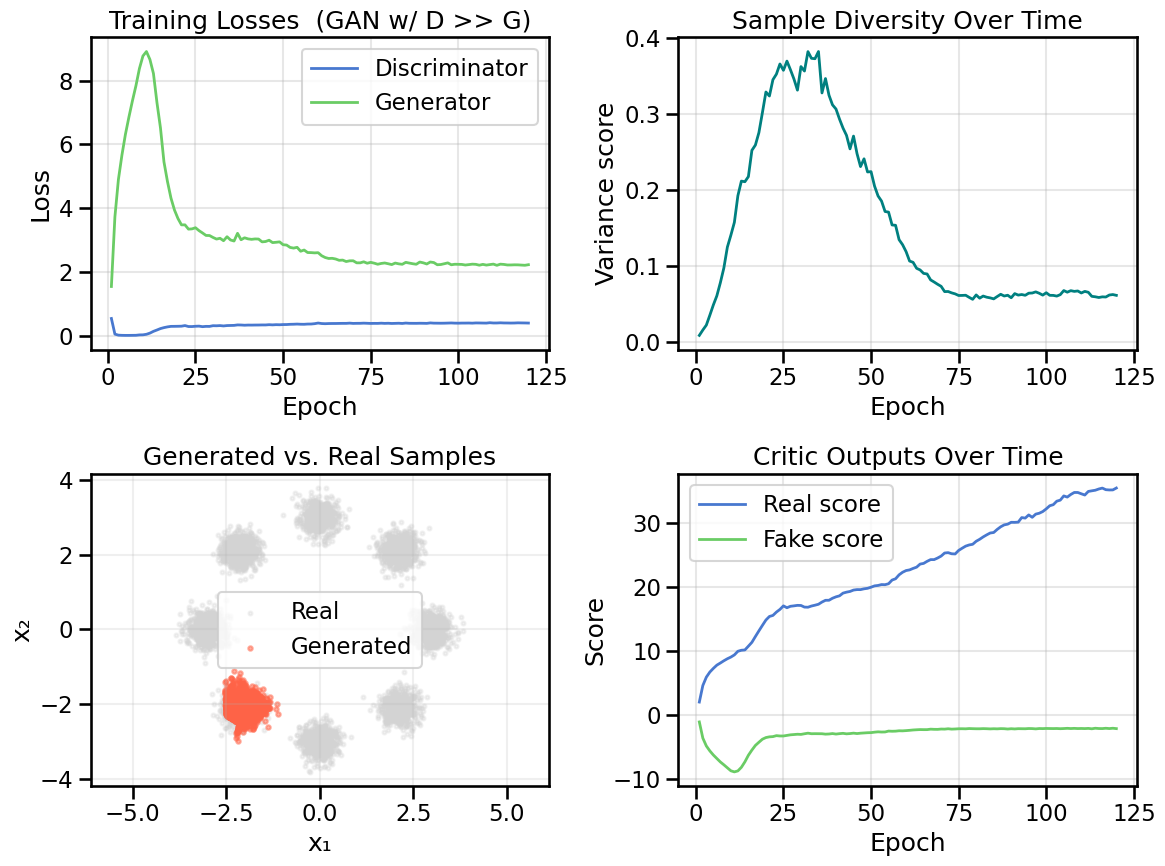

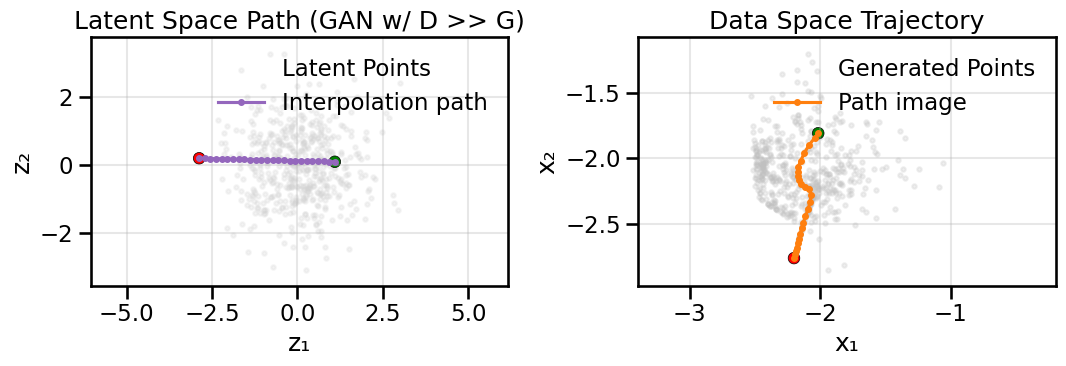

In [6]:
plot_model_diagnostics(H, X_ring, G, noise_dim=2, title_suffix=' (GAN w/ D >> G)')
plot_latent_interpolation(G, noise_dim=2, title_suffix=' (GAN w/ D >> G)')

We can also take a look at this interactively, by viewing various snapshots during training:

In [7]:
# Interactive checkpoint browser (requires ipywidgets)
if interact is None:
    print("ipywidgets not available. Install ipywidgets to use the interactive checkpoint browser.")
else:
    from ipywidgets import IntSlider, Output, VBox, Label

    out = Output()

    def show_checkpoint(idx: int):
        if not hasattr(H, "snapshots") or len(H.snapshots) == 0:
            with out:
                print("No checkpoints available. Rerun training with checkpoint_interval>0 to populate snapshots.")
            return
        cp = H.snapshots[idx]
        # Load generator state into a temporary generator instance
        G_temp = build_generator(noise_dim=2, hidden_dim=256)
        # load state dict (ensure tensors are moved to device)
        state = {k: v.to(device) for k, v in cp["state_dict"].items()}
        G_temp.load_state_dict(state)

        with out:
            out.clear_output(wait=True)
            # Plot diagnostics and latent interpolation for this checkpoint
            print(f"Checkpoint: index={idx} | epoch={cp['epoch']}")
            plot_model_diagnostics(H, X_ring, G_temp, noise_dim=2, title_suffix=f" (Checkpoint ep {cp['epoch']})")
            plot_latent_interpolation(G_temp, noise_dim=2, title_suffix=f" (Checkpoint ep {cp['epoch']})", real_samples=X_ring, latent_limits=ring_latent_limits, data_limits=ring_data_limits)

    def make_slider():
        if not hasattr(H, "snapshots") or len(H.snapshots) == 0:
            print("No checkpoints available. Rerun training with checkpoint_interval>0 to populate snapshots.")
            return
        max_idx = len(H.snapshots) - 1
        slider = IntSlider(value=0, min=0, max=max_idx, step=1, description='Checkpoint')
        def on_change(change):
            if change['name'] == 'value':
                show_checkpoint(change['new'])
        slider.observe(on_change)
        display(VBox([Label('Checkpoint browser'), slider, out]))
        # show initial
        show_checkpoint(0)

    make_slider()

## Experiment 2: When the Generator Overpowers the Discriminator

Above we saw what happens when the Discriminator overpowers the Generator. But what about the other way around? The next experiment will help illuminate what can go wrong.

::: {.callout-tip appearance="default"}
### Experiment: What happens when the Generator overpowers the Discriminator?
Below you can change the relative learning rates of the Discriminator versus the Generator to give the Generator a significant advantage:

- What happens when we turn the tables on the Discriminator, and give the Generator comparatively more power?
- How are the loss plots this time significantly different than what you saw in the first experiment?
- As you look through the training curves as well as snapshots during training, what do you notice about the generated samples? Why would an underpowered Discriminator lead to this behavior? (Hint: Play out conceptually in your head how the generator would respond in cases where the Discriminator is very weak or slow.)

:::

In [8]:
#| code-fold: false
G, D, H = train_vanilla_gan(
    X_ring, epochs=120, batch_size=256,
    lr_g=1e-4,
    lr_d=1e-5,
    hidden_dim=256, noise_dim=2, 
    checkpoint_interval=10,
    print_every=40)

Epoch 001/120 | D 1.347 | G 0.704 | Div 0.030
Epoch 040/120 | D 1.346 | G 0.751 | Div 0.015
Epoch 040/120 | D 1.346 | G 0.751 | Div 0.015
Epoch 080/120 | D 1.368 | G 0.716 | Div 0.650
Epoch 080/120 | D 1.368 | G 0.716 | Div 0.650
Epoch 120/120 | D 1.370 | G 0.731 | Div 0.343
Epoch 120/120 | D 1.370 | G 0.731 | Div 0.343


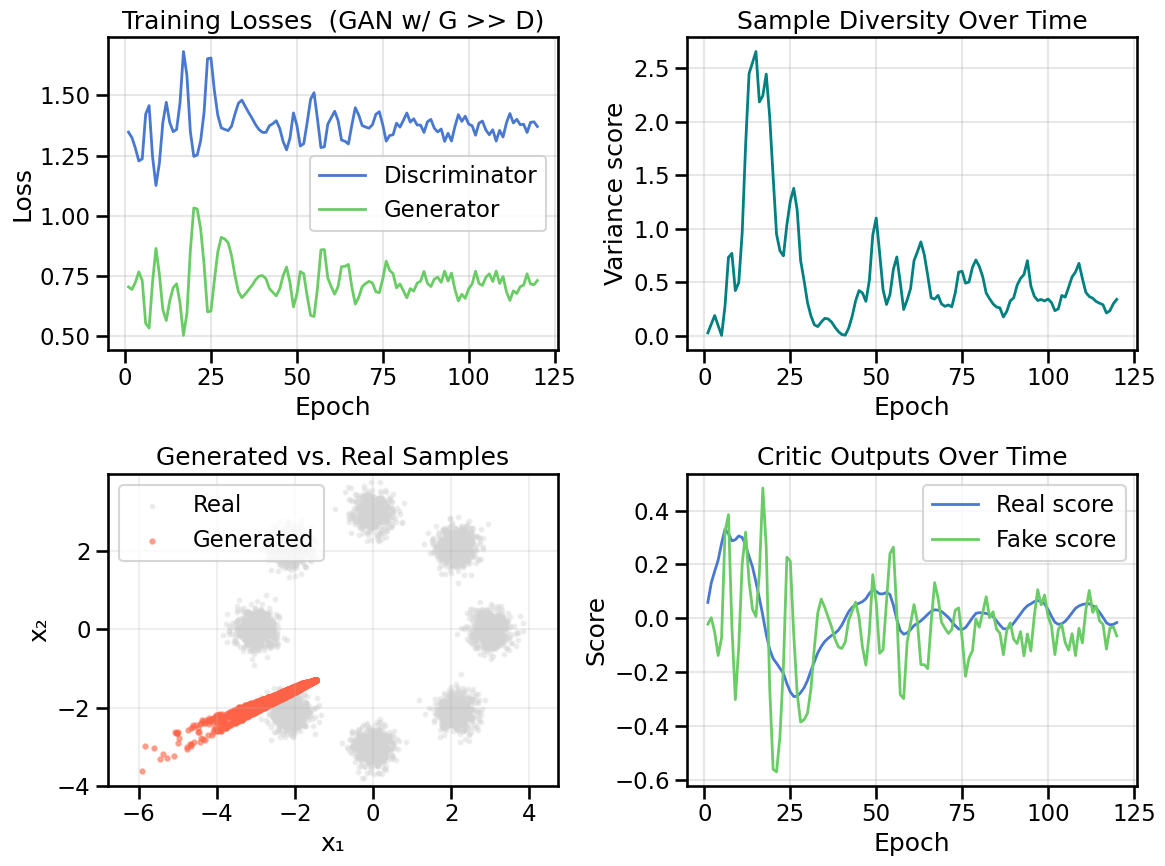

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


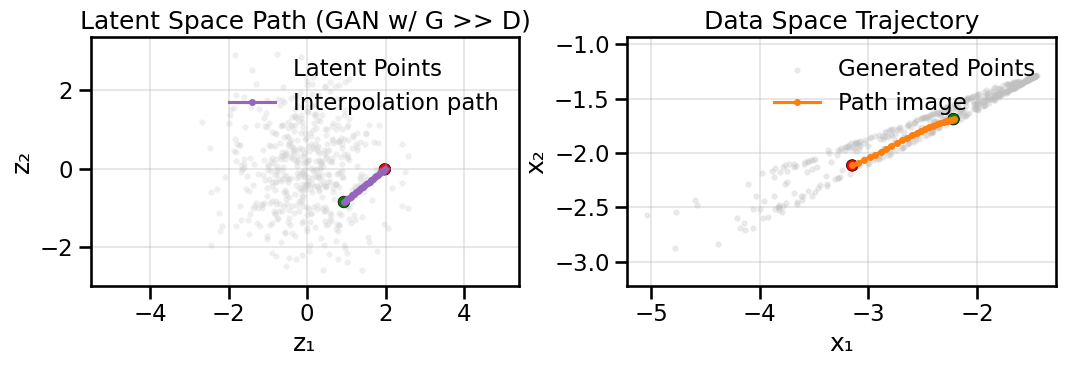

In [9]:
plot_model_diagnostics(H, X_ring, G, noise_dim=2, title_suffix=' (GAN w/ G >> D)')
plot_latent_interpolation(G, noise_dim=2, title_suffix=' (GAN w/ G >> D)')


You can also view this interactively at different training snapshots below, which might help illuminate some behavior:

In [10]:
# Interactive checkpoint browser (requires ipywidgets)
if interact is None:
    print("ipywidgets not available. Install ipywidgets to use the interactive checkpoint browser.")
else:
    from ipywidgets import IntSlider, Output, VBox, Label

    out = Output()

    def show_checkpoint(idx: int):
        if not hasattr(H, "snapshots") or len(H.snapshots) == 0:
            with out:
                print("No checkpoints available. Rerun training with checkpoint_interval>0 to populate snapshots.")
            return
        cp = H.snapshots[idx]
        # Load generator state into a temporary generator instance
        G_temp = build_generator(noise_dim=2, hidden_dim=256)
        # load state dict (ensure tensors are moved to device)
        state = {k: v.to(device) for k, v in cp["state_dict"].items()}
        G_temp.load_state_dict(state)

        with out:
            out.clear_output(wait=True)
            # Plot diagnostics and latent interpolation for this checkpoint
            print(f"Checkpoint: index={idx} | epoch={cp['epoch']}")
            plot_model_diagnostics(H, X_ring, G_temp, noise_dim=2, title_suffix=f" (Checkpoint ep {cp['epoch']})")
            plot_latent_interpolation(G_temp, noise_dim=2, title_suffix=f" (Checkpoint ep {cp['epoch']})", real_samples=X_ring, latent_limits=ring_latent_limits, data_limits=ring_data_limits)

    def make_slider():
        if not hasattr(H, "snapshots") or len(H.snapshots) == 0:
            print("No checkpoints available. Rerun training with checkpoint_interval>0 to populate snapshots.")
            return
        max_idx = len(H.snapshots) - 1
        slider = IntSlider(value=0, min=0, max=max_idx, step=1, description='Checkpoint')
        def on_change(change):
            if change['name'] == 'value':
                show_checkpoint(change['new'])
        slider.observe(on_change)
        display(VBox([Label('Checkpoint browser'), slider, out]))
        # show initial
        show_checkpoint(0)

    make_slider()

## Experiment 3: Effect of Discriminator Spectral Normalization

Part of the issue in Experiment 1 (where the Discriminator overpowers the Generator) is that the Discriminator can make very sudden and extreme changes to its decision boundary, which the Generator cannot keep up with. One way to mitigate this is to use Spectral Normalization on the Discriminator weights, which constrains the Lipschitz constant of the Discriminator function, and thus prevents it from making extreme changes to its decision boundary.

::: {.callout-tip appearance="default"}
### Experiment: How does Spectral Normalization affect the Discriminator?
Below we will activate `spectral_normalization=True` in the Discriminator, and see how this affects the training dynamics when the Discriminator is given a significant learning rate advantage over the Generator. 

- Keeping the learning rates from Experiment 1, what do you now notice about the Discriminator's training losses?
- Do different learning rates modulate this effect? You can repeat a version of Experiment 2 here if you are curious.
- In what ways has applying this spectral normalization improved the model performance? In what ways has it made it worse? Why do you think this is? (Hint: Think about what Spectral Normalization controls within a network, and what effect that would have if applied to the Discriminator in a mini-max game against the Generator.)
- Looking only at the various training curves, do you notice the effect of the Spectral normalization? Where do the effect of the Spectral Normalization show itself within the diagnostics?

:::

In [18]:
G, D, H = train_vanilla_gan(
    X_ring, epochs=240, batch_size=256,
    lr_g=1e-4,
    lr_d=5e-4,
    spectral_normalization=True,
    hidden_dim=256, noise_dim=2, 
    print_every=40)

Epoch 001/240 | D 1.299 | G 0.731 | Div 0.143
Epoch 040/240 | D 1.371 | G 0.703 | Div 4.572
Epoch 040/240 | D 1.371 | G 0.703 | Div 4.572
Epoch 080/240 | D 1.374 | G 0.700 | Div 4.610
Epoch 080/240 | D 1.374 | G 0.700 | Div 4.610
Epoch 120/240 | D 1.376 | G 0.700 | Div 4.528
Epoch 160/240 | D 1.378 | G 0.697 | Div 4.569
Epoch 200/240 | D 1.381 | G 0.697 | Div 4.568
Epoch 240/240 | D 1.383 | G 0.699 | Div 4.630


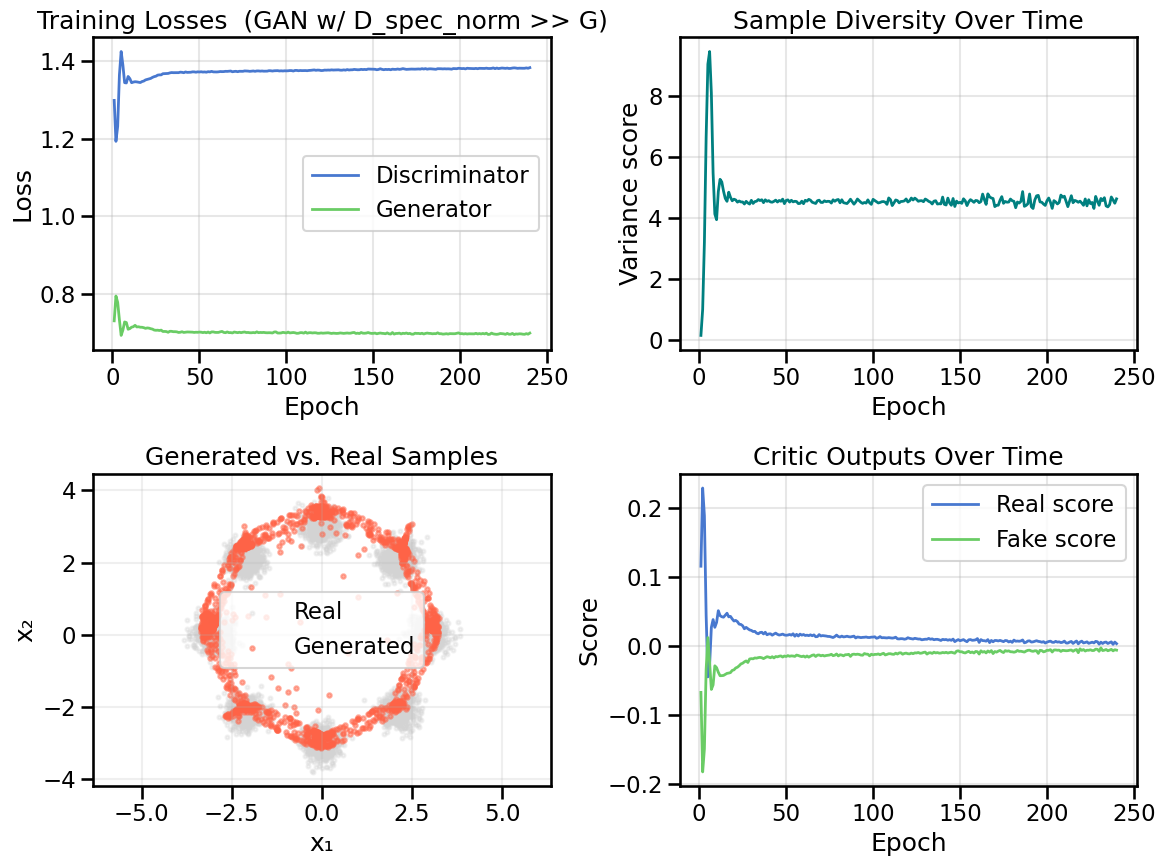

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


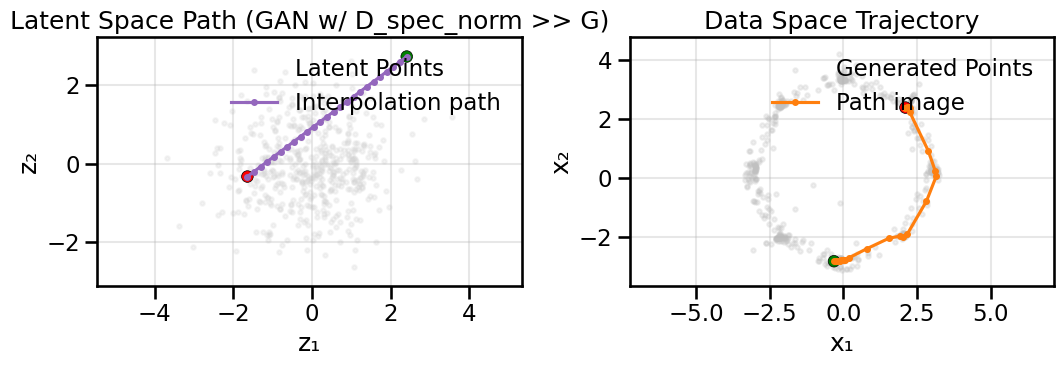

In [19]:
plot_model_diagnostics(H, X_ring, G, noise_dim=2, title_suffix=' (GAN w/ D_spec_norm >> G)')
plot_latent_interpolation(G, noise_dim=2, title_suffix=' (GAN w/ D_spec_norm >> G)')

## Summary and Next Steps

We have seen above how the mini-max formulation of a Generative Adversarial Network leads to unwanted training dynamics that need to be carefully tuned if the GAN is to perform well. In large part, we can see that this is the result of the two networks fighting each other. But is this fight really necessary? After all, the Generator is trying to learn the data distribution, and the Discriminator is just a tool to help it do so, because we didn't have a clear way to map the generated samples to the real samples in a way that directly allowed us to directly optimize something like an MSE. 

In the next notebook, we will see how we can reformulate this problem in terms of Optimal Transport, which will allow us to sidestep some of these issues and remove some of the problems cased by the mini-max game.